# Marine Heatwaves 2
# Driving mechanisms: Leeuwin Current Marine Heatwaves and El Niño–Southern Oscillation

This notebook examines the 2011 Leeuwin Current Marine Heatwave (MHW) off the coast of Western Australia and the driving role of the 2010–2011 La Niña. La Niña is the negative phase of the El Niño–Southern Oscillation (ENSO) climate cycle, where warm surface waters pile up in the western Pacific and to the north of Australia. 


This notebook examines global satellite sea surface temperature (SST) from the  NOAA  Optimum  Interpolation  Sea  Surface Temperature (OISST) dataset. The Marine Heatwave (MHW) definition of Hobday et al. (found here: https://tos.org/oceanography/assets/docs/31-2_hobday.pdf) is implemented using the the marineHeatWaves module as outlined here: https://github.com/ecjoliver/marineHeatWaves/blob/master/docs/example_synthetic.ipynb.

For more information on the OISST dataset:
https://www.ncdc.noaa.gov/oisst


The files can be found at: 
https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.html

El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

In [1]:
# Load required modules.
import time
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as stats
from datetime import date, timedelta
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Add the latitude and longitude of the data that you downloaded from the MHW tracker (must be exactly the same!).
lat = -28.875
lon = 112.875

Load in the csv files you downloaded from the MHW tracker site (depends on the lat/lon values entered above).

In [3]:
clim = pd.read_csv('data/clim_lon_{}_lat_{}.csv'.format(lon, lat))
mhws = pd.read_csv('data/event_lon_{}_lat_{}.csv'.format(lon, lat), parse_dates=[4, 5, 6])

In [7]:
oni = pd.read_csv('data/oceanic_nino_index.csv', parse_dates=[0])
soi = pd.read_csv('data/BoM_SOI_ENSO.csv', parse_dates=[0])

df = xr.Dataset({'soi': ('time', soi.soi.values), 
                 'nino': ('time', soi.nino.values)}, coords={'time': soi.time.values}) # Creates an empty xarray dataset.
df.nino[50]

<xarray.DataArray 'nino' ()>
array('none', dtype=object)
Coordinates:
    time     datetime64[ns] 1986-03-01

C:\Users\astel\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


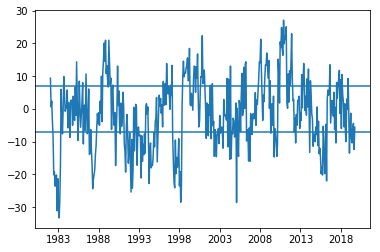

In [5]:
fig, ax = plt.subplots()
ax.plot(soi.time, soi.soi)
ax.axhline(7)
ax.axhline(-7)

In [8]:
nina = pd.read_csv('data/BoM_SOI_nina.csv', parse_dates=[0, 1])
nino = pd.read_csv('data/BoM_SOI_nino.csv', parse_dates=[0, 1])
nino

,Unnamed: 0,time_start,time_end,duration
0,0,1982-05-01,1983-04-01,12
1,1,1986-12-01,1987-09-01,10
2,2,1990-02-01,1990-03-01,2
3,3,1991-03-01,1991-05-01,3
4,4,1991-08-01,1992-04-01,9
5,5,1992-06-01,1992-07-01,2
6,6,1992-10-01,1992-11-01,2
7,7,1993-01-01,1993-10-01,10
8,8,1994-03-01,1994-12-01,10
9,9,1995-04-01,1995-05-01,2


ValueError: Could not convert object to NumPy datetime

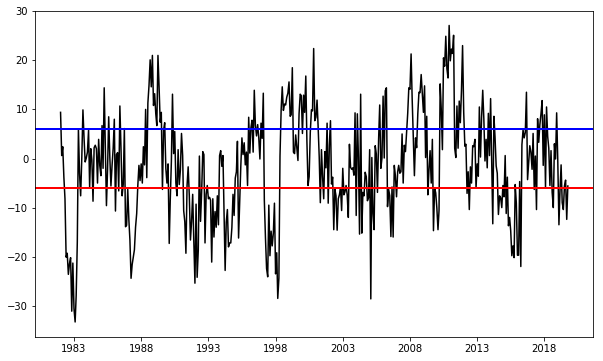

In [9]:
# t = pd.to_datetime(nino34.time.values)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.time, df.soi, color='black')

# Plot a green line at the upper and lower bounds.
ax.axhline(y=6, color='blue', linewidth=2) 
ax.axhline(y=-6, color='red', linewidth=2)

# Shades the SST anomaly red (blue) if greater (lower) than the bounds.
ax.fill_between(df.time, -6, df.soi, where=df.nino == 'nino', facecolor='red') # Red for El Nino.
ax.fill_between(df.time, 6, df.soi, where=df.nino == 'nina', facecolor='blue') # Blue for La Nina.

In [10]:
# Convert from monthly to daily values
dn = df.resample(time="1D").pad()
dn

<xarray.Dataset>
Dimensions:  (time: 13788)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2019-10-01
Data variables:
    soi      (time) float64 9.4 9.4 9.4 9.4 9.4 ... -12.4 -12.4 -12.4 -12.4 -5.6
    nino     (time) object 'none' 'none' 'none' 'none' ... 'none' 'none' 'none'

In [11]:
lag = timedelta(weeks=4*2)
mhw_evs_nina = sum(1 for n in range(len(mhws)) if dn.nino.sel(time=mhws.date_start[n] - lag) == 'nina')
mhw_evs_nino = sum(1 for n in range(len(mhws)) if dn.nino.sel(time=mhws.date_start[n] - lag) == 'nino')
print('MHW events during La Nina: {}, {:.1f}%'.format(mhw_evs_nina, (mhw_evs_nina/len(mhws))*100))
print('MHW events during El Nino: {}, {:.1f}%'.format(mhw_evs_nino, (mhw_evs_nino/len(mhws))*100))

mhw_days_nina = sum(mhws.duration[n] for n in range(len(mhws)) if dn.nino.sel(time=mhws.date_start[n] - lag) == 'nina')
mhw_days_nino = sum(mhws.duration[n] for n in range(len(mhws)) if dn.nino.sel(time=mhws.date_start[n] - lag) == 'nino')
print('MHW days during La Nina: {}, {:.1f}%'.format(mhw_days_nina, (mhw_days_nina/sum(mhws.duration))*100))
print('MHW days during El Nino: {}, {:.1f}%'.format(mhw_days_nino, (mhw_days_nino/sum(mhws.duration))*100))

MHW events during La Nina: 36, 53.7%
MHW events during El Nino: 9, 13.4%
MHW days during La Nina: 618, 60.3%
MHW days during El Nino: 75, 7.3%


In [1]:
year_start=1982
year_end=2018

Open the SST satellite data as an xarray dataset (this may be slow depending on the year range):

In [2]:
# URL of NOAA OISST daily anomaly data (SST minus climatology).  
# Note that we're not loading the mean daily SST like the first notebook.
url_anom = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom'

# Create a list of NOAA URLs in the year range.
files_anom = [f'{url_anom}.{year}.v2.nc' for year in range(year_start, year_end + 1)]

# Open files as an xarray dataset (this may take a couple of minutes).
ds = xr.open_mfdataset(files_anom)
ds

NameError: name 'xr' is not defined

In [ ]:
# # URL of NOAA OISST daily mean and daily anomaly data.
# url_sst = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean'
# url_anom = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom'

# # Create a list of NOAA URLs in the year range.
# files_sst = [f'{url_sst}.{year}.v2.nc' for year in range(year_start, year_end + 1)]
# files_anom = [f'{url_anom}.{year}.v2.nc' for year in range(year_start, year_end + 1)]

# # Open files as an xarray dataset (this may take a couple of minutes).
# # ds = xr.open_mfdataset([files_sst, files_anom])
# ds = xr.open_mfdataset(files_anom)
# # ds = ds.sel(time=slice('2010-10', '2011-06')) # Reduce the time values to load.
# ds

## Calculate the nino3.4 index:

In [ ]:
start = time.time()
# Calculate the nino3.4 index averaged over the nino3.4 area (don't change the latitude and longitudes!).
sst_anom_nino34 = ds.anom.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lon', 'lat'])

oni = sst_anom_nino34.rolling(time=3).mean(dim='time')

print('Execution time:', str(timedelta(seconds=time.time() - start)))

In [ ]:
sst_anom_nino34 = sst_anom_nino34.values
oni = oni.values

In [ ]:
fig, ax = plt.subplots()
sst_anom_nino34.plot(ax=ax, label='raw')
oni.plot(ax=ax, label='smoothed')
ax.grid()

Calculate the MHW event of the Leeuwin Current:

In [ ]:
start = time.time()
# sst_lc = ds.sst.sel(lat=lat, lon=lon, method='nearest')
sst_anom_lc = ds.anom.sel(lat=lat, lon=lon, method='nearest').values
print('Execution time:', str(timedelta(seconds=time.time() - start)))

In [ ]:
# sst_anom_lc = ds.anom.sel(lat=slice(-32, -26), lon=slice(112, 115)).mean(['lat', 'lon'])

In [ ]:
# # Calculate the SST climatology (month-to-month mean). Takes ~3 mins.
# lc_clim = dl.groupby('time.month').mean('time')
# print('Execution time:', str(timedelta(seconds=time.time() - start)))

# # Calculate the SST anomaly (SST minus climatology). Takes ~3 mins.
# lc_anom = dl.groupby('time.month') - lc_clim
# print('Execution time:', str(timedelta(seconds=time.time() - start)))

In [ ]:
dn = dn.sel(time=slice(np.datetime64('2010-01-01T00:00:00.000000000'), np.datetime64('2011-12-31T00:00:00.000000000')))
t = pd.to_datetime(dn.time.values) # Time series of the satellite SST data.
# Creating a loop of the SST long-term mean seasonal and MHW thredhold values (for time series longer than a year).
days = [] # Finding the number of days in each year (in case there is a leap year).
[days.append((date(y + 1, 1, 1) - date(y, 1, 1)).days) for y in range(year_start, year_end + 1)]
thresh = clim.thresh
seas = clim.seas
for i in range(year_end - year_start):
    thresh = np.append(thresh[:days[i]], thresh[:days[i + 1]], 0)
    seas = np.append(seas[:days[i]], seas[:days[i + 1]], 0)
    
thresh_anom = thresh - seas

In [ ]:
ev = mhws.intensity_max.idxmax() # Finds the index of the largest event.

## Plot a timeseries of the Nino 3.4 SST anomalies and Leeuwin Current SST:

In [ ]:
start = time.time()
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10), sharex=True)

# Subplot 1: Nino 3.4 anomalies.
ax1.set_title('Nino 3.4 SST anomaly (black),  mean SST (blue), \
              threshold (green), detected events (shading)')
bnd1 = 0.8 # Bound of Nino 3.4 threshold (in °C).
bnd2 = -bnd1 # Lower bound of Nino 3.4 threshold (in °C).
# Plot the Nino 3.4 SST anomaly as a black line.
ax1.plot(t, sst_anom_nino34, 'k-', linewidth=2)
ax1.plot(t, oni, 'p-', linewidth=2)
# Plots a blue line at 0°C (climatology).
ax1.axhline(y=0, color='b', linewidth=2)
# Plot a green line at the upper and lower bounds.
ax1.axhline(y=bnd1, color='g', linewidth=2) 
ax1.axhline(y=bnd2, color='g', linewidth=2)
# Shades the SST anomaly red (blue) if greater (lower) than the bounds.
ax1.fill_between(t, bnd1, sst_anom_nino34, where=sst_anom_nino34 > bnd1, facecolor='red') # Red for El Nino.
ax1.fill_between(t, bnd2, sst_anom_nino34, where=sst_anom_nino34 < bnd2, facecolor='blue') # Blue for La Nina.
# Label the y-axis.
ax1.set_ylabel('SST anomaly [°C]')
# Set the maximum and minimum SST anomaly range.
ax1.set_ylim(sst_anom_nino34.min() - 0.1, sst_anom_nino34.max() + 0.1)
# Restrict the x-axis to the data's time series (sharing x-axis, so works for both plots).
ax1.set_xlim(t[0], t[-1]) 
print('Execution time:', str(timedelta(seconds=time.time() - start)))

# Subplot 2: Leeuwin Current SST.
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
ax2.set_title('Leeuwin Current SST (black),  climatology (blue), \
              threshold (green), detected MHW events (shading)')
ax2.plot(t, sst_anom_lc, 'k-', linewidth=2)
ax2.plot(t, thresh_anom, 'g-', linewidth=2)
# Plots a blue line at 0°C (climatology).
ax2.axhline(y=0, color='b', linewidth=2)
# Find indices for closest MHW before and after event of interest and shade accordingly.
for ev0 in np.arange(ev - 3, ev + 3, 1):
    t1 = np.where(t == mhws.date_start[ev0])[0][0]
    t2 = np.where(t == mhws.date_end[ev0])[0][0]
    plt.fill_between(t[t1:t2 + 1], sst_anom_lc[t1:t2 + 1], thresh_anom[t1:t2 + 1], color=(1, 0.6, 0.5))

# Find indices for MHW start and end date of interest and shade accordingly
t1 = np.where(t == mhws.date_start[ev])[0][0]
t2 = np.where(t == mhws.date_end[ev])[0][0]
plt.fill_between(t[t1:t2 + 1], sst_anom_lc[t1:t2 + 1], thresh_anom[t1:t2 + 1], color='r')
# plt.ylim(seas.min() - 1, seas.max() + mhws.intensity_max[ev] + 0.5)
plt.ylabel('SST anomaly [°C]')
print('Execution time:', str(timedelta(seconds=time.time() - start)))
plt.savefig('Nino34_Leeuwin_Current_lon_{}_lat_{}.png'.format(lon, lat)) # Save the figure to your computer.

In [ ]:
start = time.time()
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10), sharex=True)

# Subplot 1: Nino 3.4 anomalies.
ax1.set_title('Nino 3.4 SST anomaly (black),  mean SST (blue), \
              threshold (green), detected events (shading)')
bnd1 = 0.8 # Bound of Nino 3.4 threshold (in °C).
bnd2 = -bnd1 # Lower bound of Nino 3.4 threshold (in °C).
# Plot the Nino 3.4 SST anomaly as a black line.
ax1.plot(dn.time, dn.soi, 'k-', linewidth=2)
# Plot a green line at the upper and lower bounds.
ax1.axhline(y=6, color='blue', linewidth=2) 
ax1.axhline(y=-6, color='red', linewidth=2)

# Shades the SST anomaly red (blue) if greater (lower) than the bounds.
ax1.fill_between(t, -6, dn.soi, where=dn.nino == 'nino', facecolor='red') # Red for El Nino.
ax1.fill_between(t, 6, dn.soi, where=dn.nino == 'nina', facecolor='blue') # Blue for La Nina.
# Label the y-axis.
ax1.set_ylabel('SST anomaly [°C]')
# Set the maximum and minimum SST anomaly range.
ax1.set_ylim(dn.soi.min() - 0.1, dn.soi.max() + 0.1)
# Restrict the x-axis to the data's time series (sharing x-axis, so works for both plots).
ax1.set_xlim(t[0], t[-1]) 
print('Execution time:', str(timedelta(seconds=time.time() - start)))

# Subplot 2: Leeuwin Current SST.
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
ax2.set_title('Leeuwin Current SST (black),  climatology (blue), \
              threshold (green), detected MHW events (shading)')
ax2.plot(t, sst_anom_lc, 'k-', linewidth=2)
ax2.plot(t, thresh_anom, 'g-', linewidth=2)
# Plots a blue line at 0°C (climatology).
ax2.axhline(y=0, color='b', linewidth=2)
# Find indices for closest MHW before and after event of interest and shade accordingly.
for ev0 in np.arange(ev - 3, ev + 3, 1):
    t1 = np.where(t == mhws.date_start[ev0])[0][0]
    t2 = np.where(t == mhws.date_end[ev0])[0][0]
    plt.fill_between(t[t1:t2 + 1], sst_anom_lc[t1:t2 + 1], thresh_anom[t1:t2 + 1], color=(1, 0.6, 0.5))

# Find indices for MHW start and end date of interest and shade accordingly
t1 = np.where(t == mhws.date_start[ev])[0][0]
t2 = np.where(t == mhws.date_end[ev])[0][0]
plt.fill_between(t[t1:t2 + 1], sst_anom_lc[t1:t2 + 1], thresh_anom[t1:t2 + 1], color='r')
# plt.ylim(seas.min() - 1, seas.max() + mhws.intensity_max[ev] + 0.5)
plt.ylabel('SST anomaly [°C]')
print('Execution time:', str(timedelta(seconds=time.time() - start)))
plt.savefig('Nino34_Leeuwin_Current_lon_{}_lat_{}.png'.format(lon, lat)) # Save the figure to your computer.

In [ ]:
dn.time